In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch import nn
from torch import optim
from sklearn.model_selection import KFold, StratifiedKFold
from torch.utils.data import DataLoader,TensorDataset,SubsetRandomSampler

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

In [2]:
#moudata = np.load('5 x_mou_0831_anno.npz', allow_pickle=True)
moudata = np.load('5 x_mou_0902_anno_nn.npz', allow_pickle=True)
mounmf = pd.read_pickle('6 Ws_mou_0902')
x_mou = torch.from_numpy(mounmf[1]).float()
y_mou = torch.from_numpy(moudata['y'].astype(np.int32))
y_mou = y_mou.long() - 1
dataset = TensorDataset(x_mou, y_mou)

#x_bin = (x_mou>0)*1
#x_bin = x_bin.float()
#dataset = TensorDataset(x_bin, y_mou)

inputSize = x_mou.shape[1]
outputSize = 14

In [3]:
class MLR(nn.Module):
    def __init__(self):
        super(MLR, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inputSize, outputSize)
        )
            
    def forward(self, x):
        out = self.layers(x)
        if not self.training:
            #print("TESTING MODE")
            out = F.softmax(out, dim=1)
        #out = out.view(out.shape[0], -1)
        return out

In [4]:
device = "cuda:0"
torch.manual_seed(42)
num_epochs = 30
batch_size = 64
k = 5
splits = StratifiedKFold(n_splits = k, shuffle=True, random_state=42)
loss_fn = nn.CrossEntropyLoss()
foldperf={}

In [5]:
def train(model, device, train_idx, loss_fn, optimizer):
    train_loss, train_correct=0.0,0
    model.train()

    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]

    for i in range(42):
        sample_idx=[]
        for t in np.unique(y_train):
            t_idx = np.where(y_train==t)[0]
            sample_idx.append(np.random.choice(t_idx, size=5))
        sample_idx = np.vstack(sample_idx)
        sample_idx = sample_idx.reshape(sample_idx.size)
        x_sample = x_train[sample_idx]
        y_sample = y_train[sample_idx]

        inputs,labels = x_sample.to(device), y_sample.to(device)
        optimizer.zero_grad()
        output = model(inputs.float())

        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct

def val(model, device, val_idx, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]

    inputs,labels = x_test.to(device),y_test.to(device)
    output = model(inputs)
    loss = loss_fn(output,labels)
    valid_loss += loss.item()*inputs.size(0)
    scores, predictions = torch.max(output.data,1)
    val_correct += (predictions == labels).sum().item()

    return valid_loss,val_correct

In [7]:
for fold, (train_idx,val_idx) in enumerate(splits.split(x_mou,y_mou)):
    torch.cuda.empty_cache()
    print('Fold {}'.format(fold + 1))

    x_train = x_mou[train_idx]
    y_train = y_mou[train_idx]
    train_set = TensorDataset(x_train, y_train)

    x_test = x_mou[val_idx]
    y_test = y_mou[val_idx]
    test_set = TensorDataset(x_train, y_train)
    
    model = MLR()
    model.to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct = train(model, device, train_idx, loss_fn, optimizer)
        test_loss, test_correct = val(model, device, val_idx, loss_fn)

        train_acc = train_correct / (70*42) * 100
        test_acc = test_correct / len(val_idx) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(
            epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

Fold 1
Epoch:1/30 AVG Training Loss:7582.114 AVG Test Loss:2884.383 AVG Training Acc 8.13 % AVG Test Acc 56.30 %
Epoch:2/30 AVG Training Loss:7042.399 AVG Test Loss:2877.362 AVG Training Acc 31.36 % AVG Test Acc 68.63 %
Epoch:3/30 AVG Training Loss:6684.119 AVG Test Loss:2870.056 AVG Training Acc 49.56 % AVG Test Acc 74.80 %
Epoch:4/30 AVG Training Loss:6360.587 AVG Test Loss:2861.662 AVG Training Acc 59.29 % AVG Test Acc 76.88 %
Epoch:5/30 AVG Training Loss:6134.906 AVG Test Loss:2852.959 AVG Training Acc 65.14 % AVG Test Acc 78.60 %
Epoch:6/30 AVG Training Loss:5865.245 AVG Test Loss:2843.597 AVG Training Acc 71.46 % AVG Test Acc 80.69 %
Epoch:7/30 AVG Training Loss:5632.212 AVG Test Loss:2833.772 AVG Training Acc 74.93 % AVG Test Acc 81.78 %
Epoch:8/30 AVG Training Loss:5419.335 AVG Test Loss:2823.916 AVG Training Acc 76.05 % AVG Test Acc 82.59 %
Epoch:9/30 AVG Training Loss:5254.305 AVG Test Loss:2813.873 AVG Training Acc 77.82 % AVG Test Acc 83.23 %
Epoch:10/30 AVG Training Loss:5

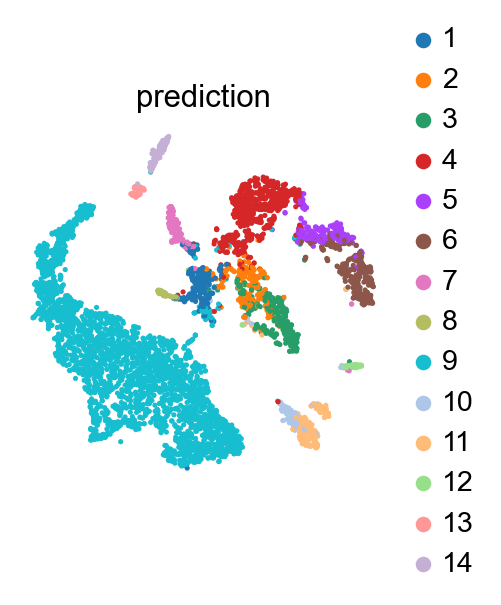

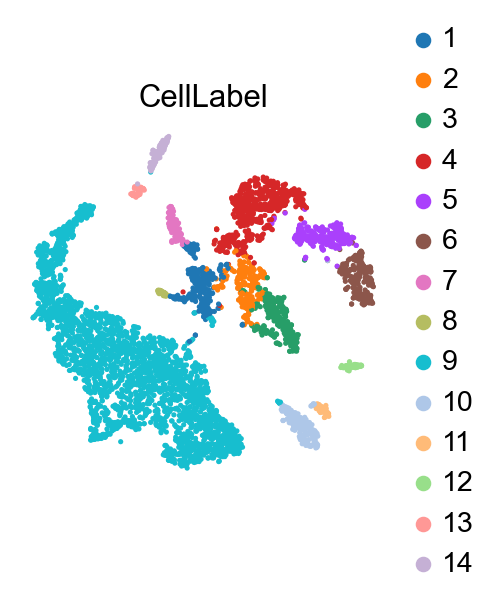

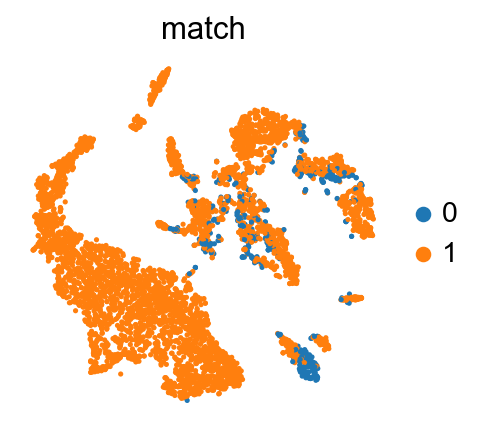

0.910921625544267

In [8]:
# r 10
adata = sc.read_h5ad('../2/3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'].astype('int64') == adata.obs['CellLabel'].astype('int64'))*1).astype('category')
sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

#torch.save(model,'MLR_NMF_r10.pt')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]

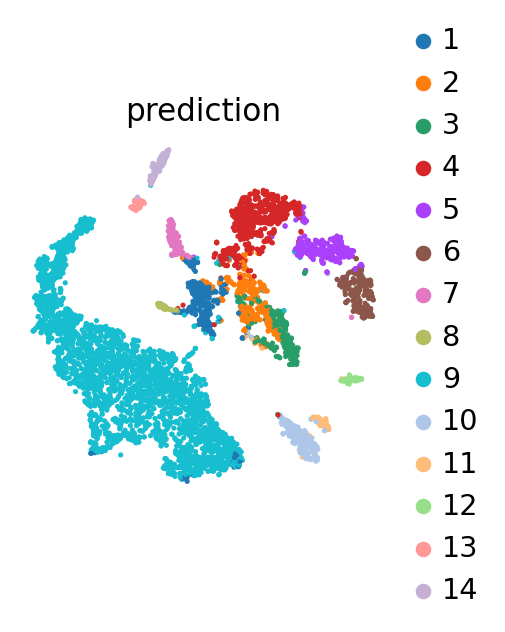

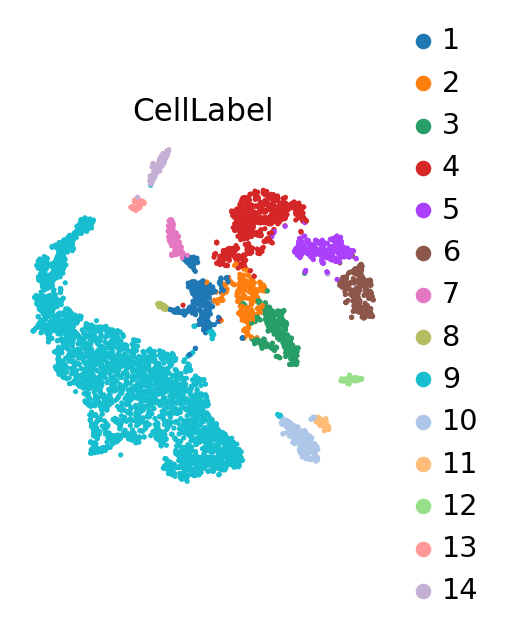

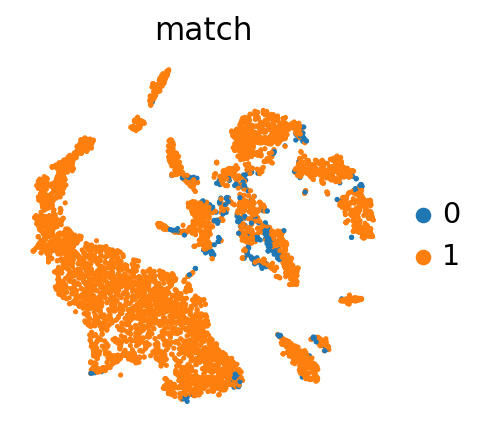

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type MLR. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


0.9406748911465893

In [17]:
# r 15
adata = sc.read_h5ad('../2/3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'].astype('int64') == adata.obs['CellLabel'].astype('int64'))*1).astype('category')

sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

torch.save(model,'MLR_NMF_r15.pt')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]

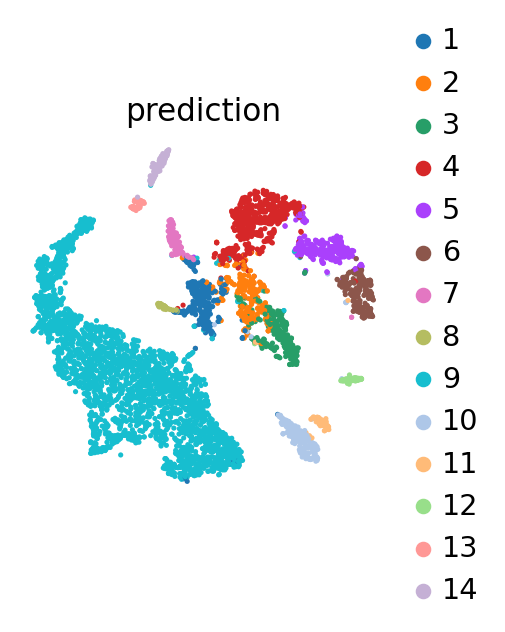

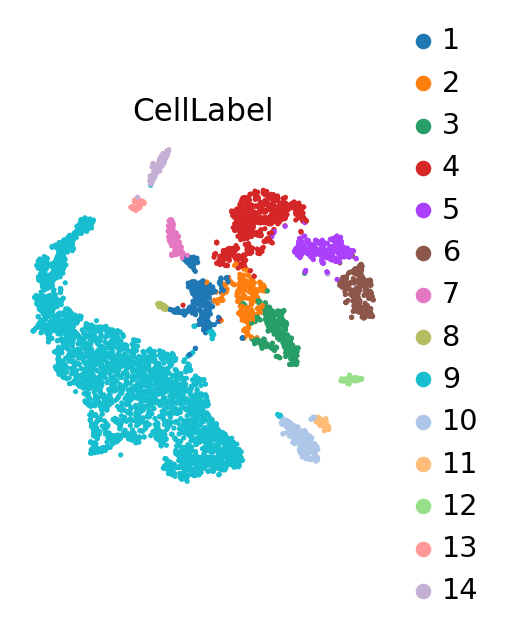

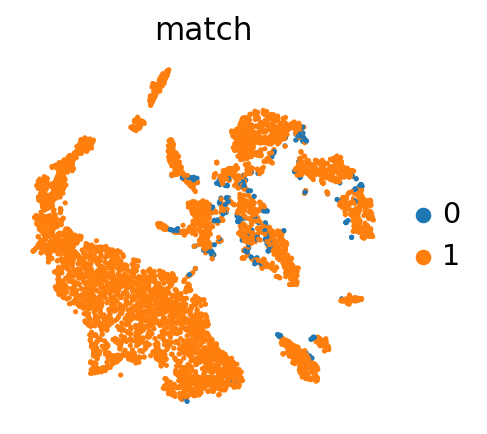

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type MLR. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


0.9557329462989841

In [23]:
# r 30
adata = sc.read_h5ad('../2/3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'].astype('int64') == adata.obs['CellLabel'].astype('int64'))*1).astype('category')

sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

torch.save(model,'MLR_NMF_r30.pt')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]

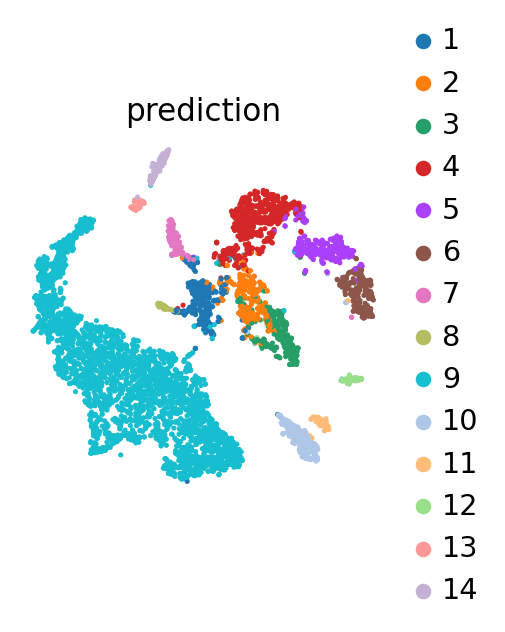

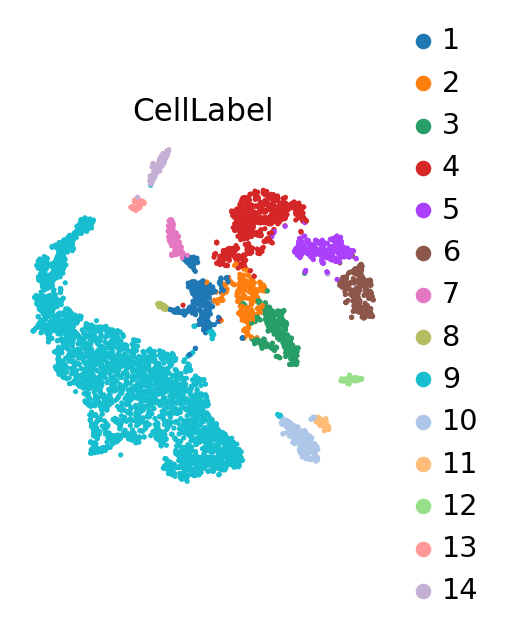

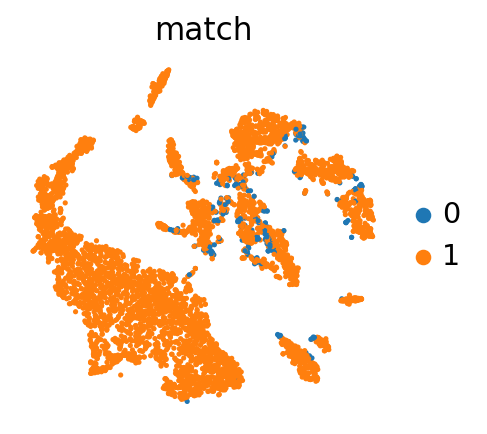

/home/lh3n19/.conda/envs/my/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type MLR. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


0.9548258345428157

In [29]:
# r 60
adata = sc.read_h5ad('../2/3 clustered_mou_0831_anno.h5ad')
v,p = torch.max(model(x_mou.to(device)),1)
adata.obs['prediction'] = p.cpu().detach().numpy() + 1
adata.obs = adata.obs.astype({'prediction': 'category'})
adata.obs['match'] = ((adata.obs['prediction'].astype('int64') == adata.obs['CellLabel'].astype('int64'))*1).astype('category')

sc.pl.tsne(adata,color='prediction')
sc.pl.tsne(adata,color='CellLabel')
sc.pl.tsne(adata,color='match')

torch.save(model,'MLR_NMF_r60.pt')

np.sum(adata.obs['match'].astype('int64'))/adata.obs['match'].shape[0]